# Development Applications in the City of Toronto

### Webscraping a dynamic Javascript website.

Having started my career as an urban planner and real estate analyst, I'm excited to combine my knowledge in this domain with newly acquired coding skills in Python. To show tech's potential role in the urban planning realm, I have built a webscraper that captures all development applications hosted on the City of Toronto's Development Application Information Centre (http://app.toronto.ca/DevelopmentApplications/mapSearchSetup.do?action=init).

While I'm very proud and extremely pleased to show the results of my Python script, it is important that I point out inconsistencies on the City's applications page. For example, some applications are stored in "Ward 00" or the wrong ward (e.g. 175 Goddard St or 3500 Eglinton Ave W). Some projects have broken links (no project page, e.g. 3035 Weston Rd) while others are not mapped and thus do not have an accessible link (e.g. 0 Rexdale Blvd "Property not mapped"). Furthermore, in my work experience as a real estate analyst, I've noticed data entries in Units or Storeys may not always be up to date as they depend on the tardiness/dilligence of city staff in updating these fields - which may not be a priority given they are often understaffed. As such, results must be interpreted with discretion. 

As of May 16th 2018, there were __1,613__ applications throughout the city's 44 wards. In addition to the more obvious application attributes a person would typically seek out (e.g. address, storeys, units), I have designed the webscraper to also collect/calculate these attributes:

   - __All Addresses__ (addition the the primary address)
   - __Types of applications__ , including their application number, date submitted, and status
   - __Supporting documents__, including Planning Rationale, Architectural Drawings, Community Services and Facility  as well as their dates submitted etc.
   - __First Activity__ and __Last Activity__ (calculated as the earliest and latest addresses amongst Supporting Docs and Types of applications)
   - __Description__ 

Here is a snippet of the dataframe:

In [1]:
import pandas as pd
source = 'DevApps2018-05-16_2300.csv'
files = pd.read_csv(source, dtype={'Ward':str}) #otherwise Ward will be coerced into an integer.
files.head()

,Address,First_Activity,Last_Activity,All_Addresses,Ward,Description,Proposed_Use,Storeys,Units,Planner,Num_apps,Apps,Supporting_Docs,Link
0,1155 ALBION RD,"Sep 21, 2015","Oct 16, 2017",['1155 ALBION RD'],01,Proposed development of a 5-storey seniors apa...,---,NaN,NaN,"Sabrina Salatino, Senior Planner, (416) 394-80...",2.0,"[['Site Plan Approval', '15 225712 WET 01 SA',...","['Planning Rationale: Sep 22, 2015: Download :...",http://app.toronto.ca/DevelopmentApplications/...
1,1790 ALBION RD,"Nov 27, 2013","Jan 25, 2018",['1790 ALBION RD'],01,To change the existing units in the industrial...,---,NaN,NaN,"Derek Brunelle, Assistant Planner, (416) 394-8...",2.0,"[['Condominium Approval', '14 150932 WET 01 CD...",['Application Form - Condo Application: May 14...,http://app.toronto.ca/DevelopmentApplications/...
2,1810 ALBION RD,"Dec 22, 2016","Apr 06, 2017",['1810 ALBION RD'],01,To construct 4 storey mausoleum.,---,4.0,0.0,"Ellen Standret, Planner, 416-394-8223, Ellen.S...",1.0,"[['Site Plan Approval', '16 270143 WET 01 SA',...","['Toronto Green Standards Checklist: Dec 22, 2...",http://app.toronto.ca/DevelopmentApplications/...
3,2045 CODLIN CRES,"Dec 22, 2017","Dec 22, 2017",['2045 CODLIN CRES'],01,The proposal is for a 4-storey hotel (140 room...,---,0.0,0.0,"Sabrina Salatino, Senior Planner, (416) 394-80...",1.0,"[['Site Plan Approval', '17 278590 WET 01 SA',...","['Urban Design Guidelines: Dec 22, 2017: Downl...",http://app.toronto.ca/DevelopmentApplications/...
4,2115 CODLIN CRES,"Aug 18, 2015","Oct 24, 2017",['2115 CODLIN CRES'],01,The application proposes to construct a one-st...,---,0.0,0.0,"Sabrina Salatino, Senior Planner, (416) 394-80...",1.0,"[['Site Plan Approval', '15 208767 WET 01 SA',...","['Toronto Green Standards Checklist: Aug 18, 2...",http://app.toronto.ca/DevelopmentApplications/...


Let's take a quick look at the number of development applications for the top 20 wards:

In [2]:
files["Ward"].value_counts()[:20]

20    169
27    114
28     82
22     75
23     71
05     61
19     59
25     51
06     44
30     43
24     39
26     38
18     38
02     36
15     35
37     35
44     35
34     34
14     32
16     31
Name: Ward, dtype: int64

Unsurprisingly, downtown Wards 20 and 27 have the most development applications tracked.

### Ontario Municipal Board appeals

Often, development projects are appealed to the Ontario Municipal Board ("the OMB")\*. This happens if applications are not given a decision within a certain period of time (e.g. 90 or 120 days, depending on the type of the application) or if the applicant does not agree with the decision of city staff. The OMB represents a second chance for the project to get approved (or rejected). 

\* *Of note, recent legislative changes will have us see an increasing number of appeals to the recently implemented Local Planning Appeals Tribunal, which replaces the OMB but essentially functions the same.*

While appealed projects are not explicitly flagged on the city's website, the scraped applications file gives us a starting point to filter them out. My methodology entails using keywords in the fields I have titled *Description* and *Apps* and searching for "appeal", "OMB", "municipal board", and "LPAT" in the former field, and "OMB Appeal" in the latter. 

Below I show how I derive a dataset showing files appealed to the OMB. The following code uses __matplotlib__ and __pandas__ libraries to explore the data and ends with an interactive map powered by __Folium__. Geocoding was done with Google's Geocoding API.

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt

### 1. Clean out broken URLs
First and foremost, I clean out all applications that have broken URLs (e.g. show "Page Error!"):

In [4]:
cleaned_files = files[files["Description"].isnull()==False]
len(cleaned_files)

1588

It appears 25 development applications (1,613 - 1,588) had broken URLs.

Now I filter out the OMB appeals using the aforementioned methodology.

In [5]:
appeal_keywords = 'ontario municipal board|appeal|local planning appeal tribunal'
appeal_keywords2 = 'OMB|LPAT|TLAB'
appealed_description = cleaned_files["Description"].str.contains(appeal_keywords, case=False)
appealed_description2 = cleaned_files["Description"].str.contains(appeal_keywords2, case=True)
appealed_apps = cleaned_files["Apps"].str.contains('OMB Appeal')

appealed_files = cleaned_files[appealed_description | appealed_description2 | appealed_apps]
print("There are",len(appealed_files["Address"]),"development projects total appealed to the OMB, as scraped from the Development Applications website. Of these,",
      len(set(appealed_files["Address"])), "have unique identifying addresses.")

There are 215 development projects total appealed to the OMB, as scraped from the Development Applications website. Of these, 202 have unique identifying addresses.


Duplicated addresses may be due to re-submissions for the same site

### 2. Create histogram by ward

Let's visualize the distribution of appeals by ward in a histogram.

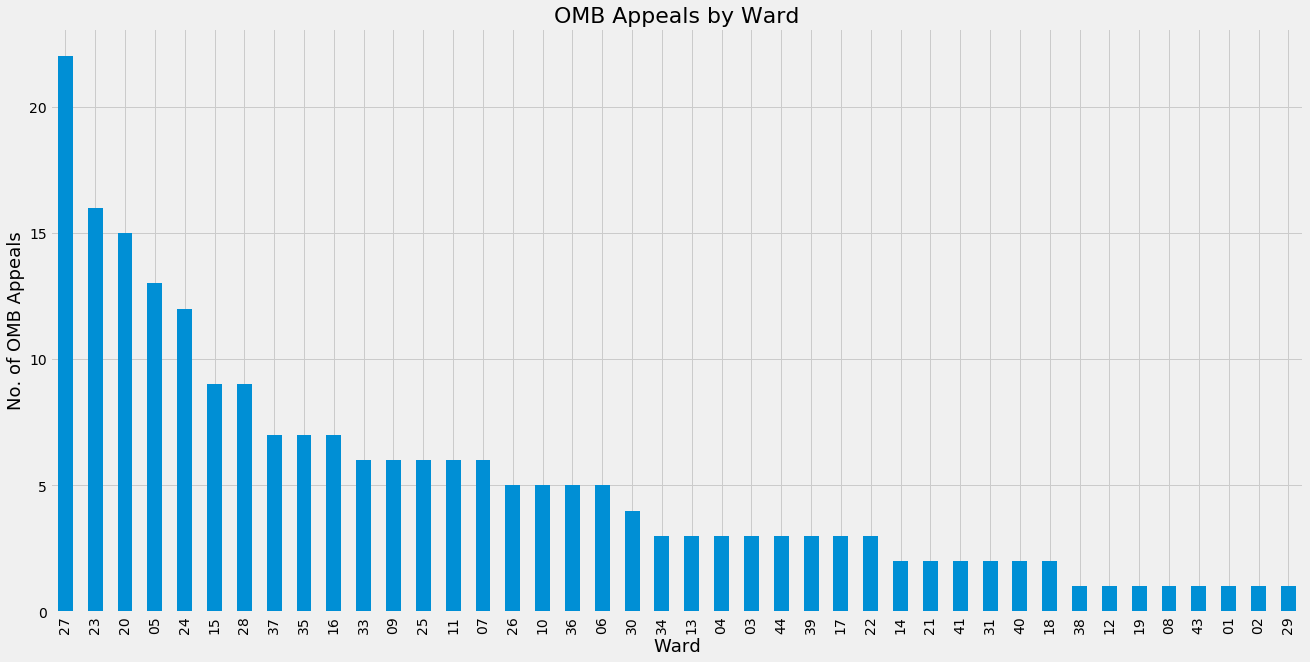

In [6]:
%matplotlib inline
from matplotlib import style
style.use("fivethirtyeight")

fig = plt.figure(figsize=(20,10))
plt.xlabel("Ward", fontsize='18')
plt.ylabel("No. of OMB Appeals", fontsize='18')

plt.title("OMB Appeals by Ward", fontsize=22)

appealed_files["Ward"].value_counts().plot(kind='bar')
plt.show()

These are the top ten wards with OMB appeals. (Ward number on the left, frequency on the right). Interestingly, the data shows Ward 23 overtakes Ward 20, with the second highest number of OMB appeals, despite a lower number of development applications. (This observation should be taken with a grain of salt as there may be older applications not tracked or uploaded to the website.) 

In [7]:
appealed_files["Ward"].value_counts()[:10]

27    22
23    16
20    15
05    13
24    12
15     9
28     9
37     7
35     7
16     7
Name: Ward, dtype: int64

### 3. Plot using Folium on Leaflet
Use googlemaps to geocode a list of addresses.

In [8]:
import folium
import googlemaps
GoogleKey = open('GoogleAPI_Key.txt','r').read() #txtfile for my own privacy - input your own API key here to reproduce.
gmaps = googlemaps.Client(key = GoogleKey)

def geocode_to_dict(addresses):
    '''Input addresses must be list.'''
    dictionary = {}
    for j in [i+', Toronto, Canada' for i in set(addresses)]:
        coded = gmaps.geocode(j)
        latlon = (coded[0]['geometry']['location']['lat'],coded[0]['geometry']['location']['lng'])
        dictionary[j.replace(", Toronto, Canada","")] = latlon
    return dictionary

dictionary = geocode_to_dict(appealed_files['Address'])

Once we have geocoded everything, we map it using folium. We also add a geojson layer to show wards, for context.

In [9]:
map = folium.Map()
Toronto = [43.706804, -79.398322] #Yonge/Eglinton
map = folium.Map(location= Toronto, tiles = 'Stamen Terrain', zoom_start = 11)

def add_markers():
    for index, row in appealed_files.iterrows():
        latlon_key = row['Address']
        latlon = dictionary[latlon_key]
        
        label = row['Address']+' (First Active: '+row['Last_Activity']+')'+'\n'+row['Description']
        formatted_label = str(label).replace("'","")
            
        folium.CircleMarker(location=latlon,
                           popup=formatted_label,
                            color='red',
                            fill_color='red',
                            fill_opacity=0.4,
                            radius=5).add_to(map)

map.choropleth(geo_data="Wards.geojson",
               fill_opacity=0.1, 
               line_opacity=0.6,
              highlight=True) 
add_markers()
map

### Discussion Points

As visualized above, we can see the majority of appeals are located downtown. However, as previously mentioned, this data is dependent on what has been entered in the City of Toronto Dev Apps Info Centre and may not be 100% accurate. If fields can be confirmed to be accurate, we would be able to perform much more powerful analyses. 

Using this as a starting point, we could potentially use logistical regression to show a correlation between appealed development applications and higher income wards (represented by aggregated census tracts), which may show us if higher income neighbourhoods are more likely to appeal residential projects. 

We could also potentially see correlation between approvals and proximity to detached residential zoning (known in the urban planning industry as "the Yellowbelt"). These stable neighbourhoods are often known to be particularly hostile to new developments and we would be able to quantify this hostility if we had good data.

We could also see how it takes on average for an application to be approved in each ward by looking to the gap between __First_Activity__ and __Last_Activity__ and grouping them by ward. However, potentially outdated statuses would render this futile. 


### Final Note

Evidently from this post alone, we can see a number of ways we can implement tech to help us understand cities better. However, as a first step, we need to demand more reliable data so that we don't fall into a "garbage in, garbage out" data-analysis trap.

As I continue to deepen and expand my knowledge of data science, analytics, and coding, I would love to bounce ideas off other curious minds and field experts to improve my existing projects and inspire new ones. I'd also love to collaborate. Feel free to reach me at fabienne.chan@gmail.com!